In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from copy import deepcopy
import pickle as pkl
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
from shapely.geometry import Point, Polygon, LineString
import sys
# Add measurement mcts python package to path
sys.path.append('../src/measurement_mcts')
from measurement_mcts.environment.static_kf_8d import measurement_model, StaticKalmanFilter

eigvals = [5.         1.37077839]


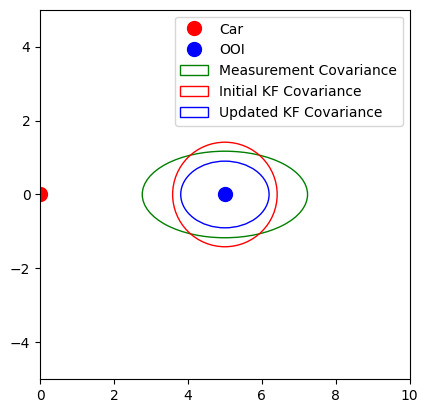

In [22]:
car_pos = np.array([0, 0])
ooi_pos = np.array([5, 0]).reshape(1,2)

# Rotate the ooi position
theta = np.radians(0)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])
ooi_pos = np.dot(R, ooi_pos.T).T

R = measurement_model(ooi_pos, np.array([0]), car_pos, 0., range_dev=1., bearing_dev=1.)

eigvals, eigvecs = np.linalg.eig(R)
print(f'eigvals = {eigvals}')
# print(f'eigvecs = {eigvecs}')

# Angle of first eigen column vector
eigvec1 = eigvecs[:,0] # First column
eigvec1_angle = np.arctan2(eigvec1[1], eigvec1[0])

# Initialize kalman filter and feed first observation
repeated_corners = np.tile(ooi_pos, (4,1))
# print(np.diag(8 * [2]))
kf = StaticKalmanFilter(repeated_corners, np.diag(8 * [2]))
P_scales, P_angle = kf.get_ellipse_scaling(kf.P_k[0:2,0:2])
# print(f'P_scales = {P_scales}')
kf.update(ooi_pos, np.array([0]), [car_pos[0], car_pos[1], 0], 0.)

Pnew_scales, Pnew_angle = kf.get_ellipse_scaling(kf.P_k[0:2,0:2])
# plot the car ooi and covariance
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 10)
ax.set_ylim(-5, 5)
ax.plot(car_pos[0], car_pos[1], 'ro', markersize=10, label='Car')
ax.plot(ooi_pos[0,0], ooi_pos[0,1], 'bo', markersize=10, label='OOI')
ax.add_patch(patches.Ellipse((ooi_pos[0,0], ooi_pos[0,1]), 2*np.sqrt(eigvals[0]), 2*np.sqrt(eigvals[1]), angle=np.degrees(eigvec1_angle), fill=False, label='Measurement Covariance', color='green'))
ax.add_patch(patches.Ellipse((ooi_pos[0,0], ooi_pos[0,1]), 2*np.sqrt(P_scales[0]), 2*np.sqrt(P_scales[1]), angle=np.degrees(P_angle), fill=False, label='Initial KF Covariance', color='red'))
ax.add_patch(patches.Ellipse((ooi_pos[0,0], ooi_pos[0,1]), 2*np.sqrt(Pnew_scales[0]), 2*np.sqrt(Pnew_scales[1]), angle=np.degrees(Pnew_angle), fill=False, label='Updated KF Covariance', color='blue'))
plt.legend()
